In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import time
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks
from keras import backend as K
from sklearn import model_selection
import pathlib

COORDINATES = ["Xmin", "Ymin", "Xmax", "Ymax"]
MAX_TRAIN_FORECASTS = 14

Using TensorFlow backend.


In [2]:
votes = pd.read_csv("../raw/train_data.csv").set_index("itemId")

In [3]:
answers = pd.read_csv("../raw/train_answers.csv").set_index("itemId")
answers.columns = COORDINATES

In [4]:
votes_test = pd.read_csv("../raw/test_data.csv").set_index("itemId")

In [28]:
def find_center(y):
    center_x = (y[0, 2] + y[0, 0]) / 2
    center_y = (y[0, 3] + y[0, 1]) / 2 
    return np.array([center_x, center_y, center_x, center_y])


def scale(x, y, err=0.1):
    center = find_center(y)
    x, y = x - np.reshape(center, (1, 1, 4)), y - np.reshape(center, (1, 4))
    
    err_x, err_y = np.random.random(2)  
    
    err_x = 1 + (2 * err_x - 1) * err
    err_y = 1 + (2 * err_y - 1) * err
    
    err = np.array([err_x, err_y, err_x, err_y])
    
    return (x * np.reshape(err, (1, 1, 4)) + np.reshape(center, (1, 1, 4)), 
            y * np.reshape(err, (1, 4)) + np.reshape(center, (1, 4)))
    

def move(x, y, err=0.1):
    center = find_center(y)
    x, y = x - np.reshape(center, (1, 1, 4)), y - np.reshape(center, (1, 4))
    
    size_x = (y[0, 2] - y[0, 0]) / 2
    size_y = (y[0, 3] - y[0, 1]) / 2
    
    err_cx, err_cy = np.random.random(2)  
    
    err_cx = (2 * size_x * err_cx - size_x) * err
    err_cy = (2 * size_y * err_cy - size_y) * err
    
    err = np.array([err_cx, err_cy, err_cx, err_cy])
    
    return x + np.reshape(err + center, (1, 1, 4)), y + np.reshape(err + center, (1, 4))
    
def aug_batch(x, y, err=0.1):
    x, y = scale(x, y, err)
    x, y = move(x, y, err)
    return x, y

In [6]:
def yield_batch(batch_size):
    item_ids = list(set(votes.index))
    while True:
        item_id = np.random.choice(item_ids, 1)
        forecasts = votes.loc[item_id].set_index("userId")
        x = np.zeros((1, len(forecasts), 4),)
        y = np.zeros((1, 4))
        
        x[0] = forecasts.sample(len(forecasts))
        y[0] = answers.loc[item_id]
        yield aug_batch(x, y)

In [7]:
def yield_batch_val():
    item_ids = set(votes.index)
    while True:
        for item_id in item_ids:
            forecasts = votes.loc[item_id].set_index("userId")
            x = np.zeros((1, len(forecasts), 4),)
            y = np.zeros((1, 4))

            x[0] = forecasts
            y[0] = answers.loc[item_id]
            yield x, y

In [8]:
def yield_batch_test():
    item_ids = votes_test.index.unique()
    for item_id in item_ids:
        forecasts = votes_test.loc[item_id].set_index("userId")
        x = np.zeros((1, len(forecasts), 4),)
        y = np.zeros((1, 4))
        x[0] = forecasts
        yield x

In [9]:
def intersection_over_union(boxes_pred, boxes_true):

    x_min = K.stack([boxes_pred[:, 0], boxes_true[:, 0]], axis=-1)
    y_min = K.stack([boxes_pred[:, 1], boxes_true[:, 1]], axis=-1)
    x_max = K.stack([boxes_pred[:, 2], boxes_true[:, 2]], axis=-1)
    y_max = K.stack([boxes_pred[:, 3], boxes_true[:, 3]], axis=-1)

    x_min = K.max(x_min, axis=-1)
    y_min = K.max(y_min, axis=-1)
    x_max = K.min(x_max, axis=-1)
    y_max = K.min(y_max, axis=-1)

    zeros = K.zeros_like(x_max)

    x_inter = K.stack([zeros, x_max - x_min], axis=-1)
    y_inter = K.stack([zeros, y_max - y_min], axis=-1)

    x_inter = K.max(x_inter, axis=-1)
    y_inter = K.max(y_inter, axis=-1)
    inter_area = x_inter * y_inter
    
    area_pred = (K.max(K.stack([zeros, boxes_pred[:, 2] - boxes_pred[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_pred[:, 3] - boxes_pred[:, 1]], axis=-1), axis=-1))
    area_true = (K.max(K.stack([zeros, boxes_true[:, 2] - boxes_true[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_true[:, 3] - boxes_true[:, 1]], axis=-1), axis=-1))

    iou = inter_area / (area_pred + area_true - inter_area + K.epsilon())
    
    return -K.mean(iou, axis=-1)

In [10]:
def make_model(filters):
    K.clear_session()
    
    y = x = layers.Input(shape=(None, 4))
    y_rez = layers.GlobalAveragePooling1D()(y)
    
    # 2 слоя с множетелем 4
    mul = 4
    y = layers.Bidirectional(layers.LSTM(
        units=filters * mul,
        return_sequences=True
    ))(y)
    y = layers.Bidirectional(layers.LSTM(
        units=filters * mul,
        return_sequences=False
    ))(y)
    
    y = layers.Dense(
        units=filters * 4,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=filters * 2,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=filters,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=filters // 2,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=4,
        activation=None
    )(y)
    y = layers.add([y_rez, y])
    y = layers.Activation("relu")(y)
    
    model = models.Model(inputs=x, outputs=y)
    model.summary()
    return model

In [26]:
def train_model(batch_size, units, epochs=100):
    model = make_model(units)
    
    lr=0.0001
    """
    model.compile(optimizer=optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                  loss="mean_absolute_error",
                  metrics=[intersection_over_union]
    )
    cb = [
        callbacks.ModelCheckpoint("../processed/model.h5", monitor="val_loss", verbose=1, save_best_only=True),
        callbacks.EarlyStopping(monitor='val_intersection_over_union', patience=epochs // 10, min_delta=0.0001, verbose=10),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1, verbose=1)
    ]
    rez = model.fit_generator(
        yield_batch(batch_size),
        steps_per_epoch=1000 // batch_size,
        epochs=epochs,
        callbacks=cb,
        validation_data=yield_batch_val(),
        validation_steps=len(set(votes.index))
    )"""
    
    model.compile(optimizer=optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                  loss=intersection_over_union,
                  metrics=None
    )
    cb = [
        callbacks.ModelCheckpoint("../processed/model.h5", monitor="val_loss", verbose=1, save_best_only=True),
        callbacks.EarlyStopping(monitor='val_loss', patience=epochs // 10, min_delta=0.0001, verbose=10),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1, verbose=1)
    ]
    rez = model.fit_generator(
        yield_batch(batch_size),
        steps_per_epoch=1000 // batch_size,
        epochs=epochs,
        callbacks=cb,
        validation_data=yield_batch_val(),
        validation_steps=len(set(votes.index))
    )
    return rez, model

In [27]:
rez, model = train_model(1, 32)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 4)      0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, None, 256)    136192      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 256)          394240      bidirectional_1[0][0]            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       bidirectional_2[0][0]            
__________________________________________________________________________________________________
dense_2 (D

1000/1000 [==============================] - 16s 16ms/step - loss: -0.5721 - val_loss: -0.5722

Epoch 00026: val_loss improved from -0.57139 to -0.57223, saving model to ../processed/model.h5
Epoch 27/100
1000/1000 [==============================] - 16s 16ms/step - loss: -0.5651 - val_loss: -0.5736

Epoch 00027: val_loss improved from -0.57223 to -0.57361, saving model to ../processed/model.h5
Epoch 28/100
1000/1000 [==============================] - 16s 16ms/step - loss: -0.5744 - val_loss: -0.5733

Epoch 00028: val_loss did not improve from -0.57361

Epoch 00028: ReduceLROnPlateau reducing learning rate to 8.589933713665232e-06.
Epoch 29/100
1000/1000 [==============================] - 16s 16ms/step - loss: -0.5753 - val_loss: -0.5739

Epoch 00029: val_loss improved from -0.57361 to -0.57387, saving model to ../processed/model.h5
Epoch 30/100
1000/1000 [==============================] - 16s 16ms/step - loss: -0.5648 - val_loss: -0.5735

Epoch 00030: val_loss did not improve from -0.5

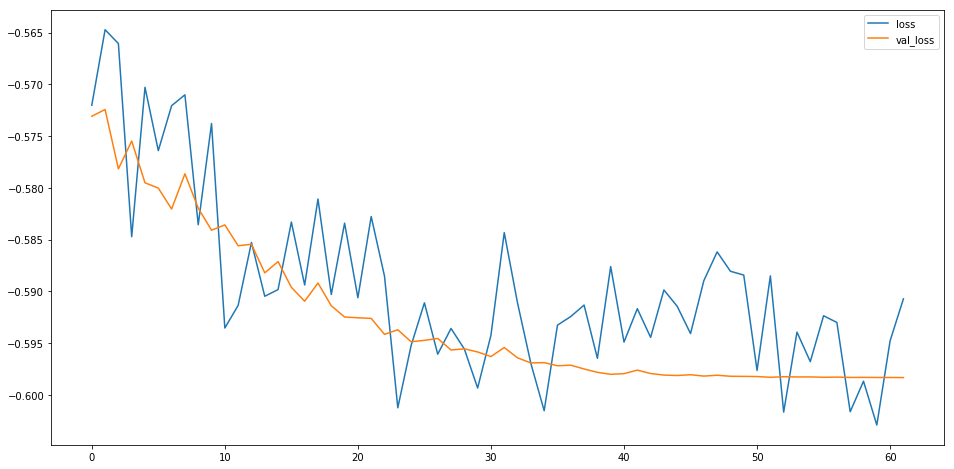

In [20]:
# 0.5983 - 0.58725
pd.DataFrame(rez.history)[["loss", "val_loss"]].plot(figsize=(16, 8))

In [21]:
def make_forecast(model):
    subdir = time.strftime('%Y-%m-%d_%H-%M')
    path = pathlib.Path(f"../processed/{subdir}")
    path.mkdir(exist_ok=True)
    feat = yield_batch_test()
    df = model.predict_generator(feat, steps=len(votes_test.index.unique()))
    df = pd.DataFrame(df, index=votes_test.index.unique())
    df.to_csv(path / "_sub_full.csv", header=False)
    # path.rename(path.parent / f"{subdir}-{score:0.1f}")

In [22]:
make_forecast(model)